In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr No Interpolated Samples, Testing Pop, Twins.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(399, 148)
(399, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
399/399 [==============================] - 1s 2ms/step - loss: 0.1942
Epoch 2/150
399/399 [==============================] - 0s 301us/step - loss: 0.1350
Epoch 3/150
399/399 [==============================] - 0s 281us/step - loss: 0.1242
Epoch 4/150
399/399 [==============================] - 0s 261us/step - loss: 0.1201
Epoch 5/150
399/399 [==============================] - 0s 281us/step - loss: 0.1170
Epoch 6/150
399/399 [==============================] - 0s 281us/step - loss: 0.1153
Epoch 7/150
399/399 [==============================] - 0s 301us/step - loss: 0.1131
Epoch 8/150
399/399 [==============================] - 0s 301us/step - loss: 0.1124
Epoch 9/150
399/399 [==============================] - 0s 281us/step - loss: 0.1118
Epoch 10/150
399/399 [==============================] - 0s 261us/step - loss: 0.1092
Epoch 11/150
399/399 [==============================] - 0s 274us/step - loss: 0.1091


399/399 [==============================] - 0s 341us/step - loss: 0.0921
Epoch 97/150
399/399 [==============================] - 0s 313us/step - loss: 0.0918
Epoch 98/150
399/399 [==============================] - 0s 321us/step - loss: 0.0917
Epoch 99/150
399/399 [==============================] - 0s 356us/step - loss: 0.0918
Epoch 100/150
399/399 [==============================] - 0s 341us/step - loss: 0.0918
Epoch 101/150
399/399 [==============================] - 0s 321us/step - loss: 0.0913
Epoch 102/150
399/399 [==============================] - 0s 341us/step - loss: 0.0921
Epoch 103/150
399/399 [==============================] - 0s 361us/step - loss: 0.0915
Epoch 104/150
399/399 [==============================] - 0s 321us/step - loss: 0.0916
Epoch 105/150
399/399 [==============================] - 0s 361us/step - loss: 0.0914
Epoch 106/150
399/399 [==============================] - 0s 342us/step - loss: 0.0917
Epoch 107/150
399/399 [==============================] - 0s 341us/step 

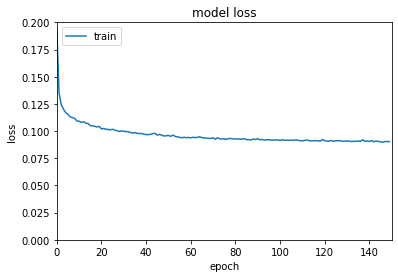

In [2]:
parsee = ct_sheet.sheet_names[2]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142,'MATCH BASC2', 'ATP', 'HYP', 'MATCH 2YR'], axis=1)  

parsee2 = ct_sheet.sheet_names[3]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142,'MATCH BASC2', 'ATP', 'HYP'], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
#Have to standardize data. Scikit learn here. Need to create stratified K folds to avoid uneven distribution of risk groups.pcaCT1Y = PCA(n_components=150) #150 Features
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledSA2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, scaled_labels, test_size=0.10, random_state=20)

#Size of encoded representation
#{'batch_size': 10, 'dropout': 0.15, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 40}
input_size = 148
hidden_size = 100
hidden_size_2 = 40
encoding_dim = 25
dropout = 0.15

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_2y, scaled_data_1y,
epochs=150,
batch_size=10,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [6]:
test_1y = pd.ExcelFile("Testing Population.xlsx") 
parsee = test_1y.sheet_names[1]
print(parsee)
data = test_1y.parse(parsee)
data_features_test = data.loc[:, data.columns] 
data_features_test = data_features_test.drop(['ROI',11142,12142,'MATCH BASC2', 'ATP', 'HYP'], axis=1)
scaled_data_test = scaler.transform(data_features_test)
print(scaled_data_test.shape)

predicted_1yr_sa = autoencoder.predict(scaled_data_test)

1yr SA
(20, 148)


In [7]:
print(predicted_1yr_sa)

[[0.30264094 0.5141932  0.38862878 ... 0.2776899  0.12306838 0.2126411 ]
 [0.27639022 0.25126785 0.3816859  ... 0.17458265 0.17765214 0.22067153]
 [0.24683738 0.32695967 0.37797442 ... 0.2029506  0.24119265 0.34334734]
 ...
 [0.23404314 0.25501305 0.3459425  ... 0.17942898 0.26410264 0.24199301]
 [0.2193752  0.42893678 0.340062   ... 0.14814328 0.27239308 0.23436992]
 [0.16982009 0.35599256 0.36574474 ... 0.3243422  0.26160774 0.26667047]]


In [8]:
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y_test = scaler.inverse_transform(predicted_1yr_sa)

C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
df = pd.DataFrame(predicted_1yr_sa)
df.to_excel("Interpolated Test SA 1y.xlsx", index=False)
df = pd.DataFrame(scaled_data_1y_test)
df.to_excel("Interpolated Test Transformed SA 1y.xlsx", index=False)

In [16]:
CT1y = pd.ExcelFile("Interpolated Test CT 1y.xlsx") 
parsee = CT1y.sheet_names[0]
data = CT1y.parse(parsee)
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI'], axis=1)  
scaler_filename = "IBIS_scaledCT1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.inverse_transform(data_features)
df = pd.DataFrame(scaled_data_1y)
df.to_excel("Transformed Interpolated CT1y.xlsx", index=False)

SA1y = pd.ExcelFile("Interpolated Test SA 1y.xlsx") 
parsee = SA1y.sheet_names[0]
data = SA1y.parse(parsee)
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI'], axis=1)  
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.inverse_transform(data_features)
df = pd.DataFrame(scaled_data_1y)
df.to_excel("Transformed Interpolated SA1y.xlsx", index=False)

C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
